# Neural Network Training

In [14]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class Layer :
    def __init__(self,weight,bias) :
        self.weight = weight
        self.bias =  bias
        
    def activationSigmoid(self,input) : #Sigmoid
        sigmoid = torch.sigmoid(input)
        return sigmoid
    
    def activationRelu(self,input) : #ReLu
        m = nn.ReLU()
        return m(input)
    
    def activationSM(self,input) : #SoftMax
        #A = torch.exp(input) / torch.sum(torch.exp(input))
        #return A
        m = nn.Softmax(dim=1)
        return m(input)
        
    def forward1(self, input) :
        output=(torch.matmul(input.double(),self.weight.double()))+self.bias
        return output,self.activationRelu(output).double()
    
    
    def forward2(self, input) :
        output=(torch.matmul(input.double(),self.weight.double()))+self.bias
        return output,self.activationSM(output).double()
        
    
       
class Network:
    def __init__(self,w1,b1,w2,b2, batch_size = 10):
        self.batch_size = batch_size
        # network
        self.layer1 = Layer(w1,b1)
        self.layer2 = Layer(w2,b2)

    def forward1(self, x):
        pred,a = self.layer1.forward1(x)
        return pred,a
    
    def forward2(self, x):
        pred,y = self.layer2.forward2(x)
        return pred,y

    
    def single_processing(self, input, target) :
            pred1,error1 = self.forward1(input)
            pred2,error2 = self.forward2(error1)
            return pred1,error1,pred2,error2
            
    
    def evaluate(self, pred, target) : #L1
        loss = nn.L1Loss()
        output = loss(pred,target)
        return output        
                
    #Create batch, then process each batch
    def batch_processing(self, input, target) :
        for i in range(0,len(input)-1,2):
            new_len=[input[i].tolist(),input[i+1].tolist()]
            new_ten=torch.Tensor(new_len)
            new_tar=[target[i].tolist(),target[i+1].tolist()]
            new_tar2=torch.Tensor(new_tar)
            self.single_processing(new_ten,new_tar2)

# Load Data

In [2]:
trainset= MNIST('dataset_mnist',True, download= True)
trainset= MNIST('dataset_mnist',False, download= True)

In [3]:
trainset.data.shape

torch.Size([10000, 28, 28])

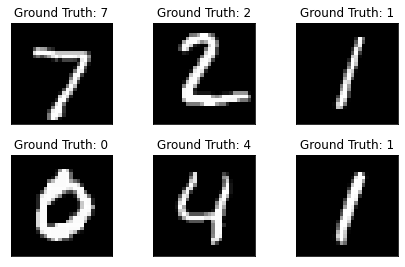

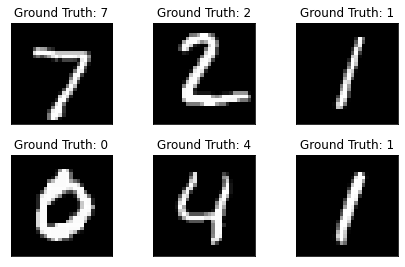

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(trainset[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(trainset.targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:

print(trainset.targets)

tensor([7, 2, 1,  ..., 4, 5, 6])


# Modeling Data

In [8]:
x_trains=trainset.data
y_train=trainset.targets

#modeling
x_train=x_trains.reshape(-1,28*28)
x_train=x_train.float()
x_train=x_train/255
x_testing=x_train
y_testing=y_train

#train
x_train=x_train[:8000]
y_train=y_train[:8000]
print(x_train.shape)

#testing
x_testing=x_testing[8000:]
y_testing=y_testing[8000:]
#print(x_testing[0]==x_train[0])

torch.Size([8000, 784])


# Call Neural Network Training Class

In [18]:
seed=52
learning_rate=0.01

m, n = x_train.shape
print (m,n)

                
def Y_res(Y):
    Y_res = np.zeros((list(y_train.shape)[0], 10))
    Y_res[np.arange(list(y_train.shape)[0]), Y] = 1
    #one_hot_Y = one_hot_Y.T
    return Y_res.astype(float)
   
def ReLU_deriv(Z):
    return (Z > 0) * 1
    
    
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
        Z1=Z1.numpy()
        Z2=Z2.numpy()
        A1=A1.numpy()
        A2=A2.numpy()
        W2=W2.numpy()
        W1=W1.numpy()
        Y_result = Y_res(Y)
        dZ2 = A2 - Y_result
        dW2 = 1 / m * dZ2.T.dot(A1)
        db2 = 1 / m * np.sum(dZ2)
        
        dZ1 = W2.T.dot(dZ2.T) * ReLU_deriv(Z1).T
        dW1 = 1 / m * dZ1.dot(X)
        db1 = 1 / m * np.sum(dZ1)

        return torch.tensor(dW1), torch.tensor(db1), torch.tensor(dW2), torch.tensor(db2)
        
def get_predictions(A2):
    return torch.argmax(A2, 0)

def get_accuracy(predictions, Y):
    acc=0
    print(predictions.size())
    for i in range (m):
        if predictions[i]==Y[i]:
            acc=acc+1
            #print("sama",predictions[i],Y[i])
    #return torch.sum(predictions == Y) / m
    return acc / m
    
def forward_prop(w1, b1, w2, b2 , X):
    model = Network(w1,b1,w2,b2)
    pred1,error1,pred2,error2=model.single_processing(x_train,y_train)
    return pred1.double(), error1.double(), pred2.double(), error2.double()

def forward_propValid(w1, b1, w2, b2 , X):
    model = Network(w1,b1,w2,b2)
    pred1,error1,pred2,error2=model.single_processing(x_testing,y_testing)
    return pred1.double(), error1.double(), pred2.double(), error2.double()
        
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - (alpha * dW1).T
    b1 = b1 - alpha * db1
    W2 = W2 - (alpha * dW2).T  
    b2 = b2 - alpha * db2
    return torch.tensor(W1), torch.tensor(b1),torch.tensor(W2), torch.tensor(b2)

def init_params():
    torch.manual_seed(52)
#     w1 = torch.randn((784,10)) 
#     b1 =  torch.randn((10))
#     #layer2
#     w2 = torch.randn((10,10))
#     b2 =  torch.randn((10))
    
    w1 = torch.randn((784,10))  * np.sqrt(1./(784))
    b1 =  torch.randn((10)) * np.sqrt(1./10)
    #layer2
    w2 = torch.randn((10,10))* np.sqrt(1./20)
    b2 =  torch.randn((10)) * np.sqrt(1./(784))
    
    return w1,b1,w2,b2

def weight_decay(X):
    return X


       
def gradient_descent(X, Y, alpha, iterations,stop):
    w1, b1, w2, b2 = init_params()
    fatal=0
    E1=0 
    for i in range(iterations):
        #print("awal: ",w2)
        Z1, A1, Z2, A2 = forward_prop(w1,b1,w2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, w1, w2, X, Y)
        w1,b1,w2, b2 = update_params(w1,b1,w2, b2, dW1, db1, dW2, db2,alpha)
        #print("Akhir: ",w2)
        if(i%10==0):
            print("Iteration: ", i)
            predictions = get_predictions(A2.t())
            print("Predict: ", predictions, "Y:", Y)
            print(get_accuracy(predictions, Y))
            #######EARLY_STOP###############
            if(E1>get_accuracy(predictions, Y)):
                fatal=fatal+1
                E1=E1
                print(fatal)
            else:
                E1=get_accuracy(predictions, Y)
                fatal=0
            if(fatal==stop):
                    return w1,b1,w2, b2
                
            
    return w1,b1,w2, b2


W1, b1, W2, b2 = gradient_descent(x_train, y_train, 0.01, 10000,8)


8000 784
Iteration:  0
Predict:  tensor([1, 3, 5,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.07575
torch.Size([8000])
torch.Size([8000])


C:\Users\Intel\AppData\Local\Temp\ipykernel_10096\2310132621.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(W1), torch.tensor(b1),torch.tensor(W2), torch.tensor(b2)


Iteration:  10
Predict:  tensor([1, 3, 5,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.083
torch.Size([8000])
torch.Size([8000])
Iteration:  20
Predict:  tensor([1, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.090125
torch.Size([8000])
torch.Size([8000])
Iteration:  30
Predict:  tensor([3, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.09575
torch.Size([8000])
torch.Size([8000])
Iteration:  40
Predict:  tensor([3, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.1025
torch.Size([8000])
torch.Size([8000])
Iteration:  50
Predict:  tensor([3, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.109375
torch.Size([8000])
torch.Size([8000])
Iteration:  60
Predict:  tensor([3, 3, 3,  ..., 3, 3, 3]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.114875
torch.Size([8000])
torch.Size([8000])
Iteration:  70
Predict:  tensor([3, 3, 3,  ...

Iteration:  530
Predict:  tensor([7, 3, 1,  ..., 3, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.717875
torch.Size([8000])
torch.Size([8000])
Iteration:  540
Predict:  tensor([7, 3, 1,  ..., 3, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.722
torch.Size([8000])
torch.Size([8000])
Iteration:  550
Predict:  tensor([7, 3, 1,  ..., 3, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.725875
torch.Size([8000])
torch.Size([8000])
Iteration:  560
Predict:  tensor([7, 3, 1,  ..., 3, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.730125
torch.Size([8000])
torch.Size([8000])
Iteration:  570
Predict:  tensor([7, 3, 1,  ..., 3, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.73375
torch.Size([8000])
torch.Size([8000])
Iteration:  580
Predict:  tensor([7, 3, 1,  ..., 3, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.738
torch.Size([8000])
torch.Size([8000])
Iteration:  590
Predict:  tensor([7, 3, 1

Iteration:  1050
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.818625
torch.Size([8000])
torch.Size([8000])
Iteration:  1060
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.819375
torch.Size([8000])
torch.Size([8000])
Iteration:  1070
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.819875
torch.Size([8000])
torch.Size([8000])
Iteration:  1080
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.8205
torch.Size([8000])
torch.Size([8000])
Iteration:  1090
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.821375
torch.Size([8000])
torch.Size([8000])
Iteration:  1100
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.822875
torch.Size([8000])
torch.Size([8000])
Iteration:  1110
Predict:  ten

Iteration:  1560
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.85025
torch.Size([8000])
torch.Size([8000])
Iteration:  1570
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.85125
torch.Size([8000])
torch.Size([8000])
Iteration:  1580
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.851375
torch.Size([8000])
torch.Size([8000])
Iteration:  1590
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.8515
torch.Size([8000])
torch.Size([8000])
Iteration:  1600
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.85175
torch.Size([8000])
torch.Size([8000])
Iteration:  1610
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.852375
torch.Size([8000])
torch.Size([8000])
Iteration:  1620
Predict:  tensor

Iteration:  2070
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.869625
torch.Size([8000])
torch.Size([8000])
Iteration:  2080
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.87
torch.Size([8000])
torch.Size([8000])
Iteration:  2090
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.87025
torch.Size([8000])
torch.Size([8000])
Iteration:  2100
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.870625
torch.Size([8000])
torch.Size([8000])
Iteration:  2110
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.870875
torch.Size([8000])
torch.Size([8000])
Iteration:  2120
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.871375
torch.Size([8000])
torch.Size([8000])
Iteration:  2130
Predict:  tensor

Iteration:  2580
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.884
torch.Size([8000])
torch.Size([8000])
Iteration:  2590
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.884125
torch.Size([8000])
torch.Size([8000])
Iteration:  2600
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.884125
torch.Size([8000])
torch.Size([8000])
Iteration:  2610
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.8845
torch.Size([8000])
torch.Size([8000])
Iteration:  2620
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.884875
torch.Size([8000])
torch.Size([8000])
Iteration:  2630
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.884875
torch.Size([8000])
torch.Size([8000])
Iteration:  2640
Predict:  tensor

Iteration:  3100
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.89125
torch.Size([8000])
torch.Size([8000])
Iteration:  3110
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.89125
torch.Size([8000])
torch.Size([8000])
Iteration:  3120
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.891375
torch.Size([8000])
torch.Size([8000])
Iteration:  3130
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.891625
torch.Size([8000])
torch.Size([8000])
Iteration:  3140
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.891875
torch.Size([8000])
torch.Size([8000])
Iteration:  3150
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.892
torch.Size([8000])
torch.Size([8000])
Iteration:  3160
Predict:  tensor

Iteration:  3610
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.898
torch.Size([8000])
torch.Size([8000])
Iteration:  3620
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.898
torch.Size([8000])
torch.Size([8000])
Iteration:  3630
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.89825
torch.Size([8000])
torch.Size([8000])
Iteration:  3640
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.8985
torch.Size([8000])
torch.Size([8000])
Iteration:  3650
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.89875
torch.Size([8000])
torch.Size([8000])
Iteration:  3660
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.899125
torch.Size([8000])
torch.Size([8000])
Iteration:  3670
Predict:  tensor([7, 

Iteration:  4130
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9035
torch.Size([8000])
5
Iteration:  4140
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9035
torch.Size([8000])
6
Iteration:  4150
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9035
torch.Size([8000])
7
Iteration:  4160
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.90375
torch.Size([8000])
torch.Size([8000])
Iteration:  4170
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.90375
torch.Size([8000])
torch.Size([8000])
Iteration:  4180
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.90425
torch.Size([8000])
torch.Size([8000])
Iteration:  4190
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5,

Iteration:  4650
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.908
torch.Size([8000])
torch.Size([8000])
Iteration:  4660
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.90825
torch.Size([8000])
torch.Size([8000])
Iteration:  4670
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.908375
torch.Size([8000])
torch.Size([8000])
Iteration:  4680
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.908375
torch.Size([8000])
torch.Size([8000])
Iteration:  4690
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9085
torch.Size([8000])
torch.Size([8000])
Iteration:  4700
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.908625
torch.Size([8000])
torch.Size([8000])
Iteration:  4710
Predict:  tensor(

Iteration:  5170
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.91175
torch.Size([8000])
torch.Size([8000])
Iteration:  5180
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.91175
torch.Size([8000])
torch.Size([8000])
Iteration:  5190
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.912
torch.Size([8000])
torch.Size([8000])
Iteration:  5200
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.912
torch.Size([8000])
torch.Size([8000])
Iteration:  5210
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.912
torch.Size([8000])
torch.Size([8000])
Iteration:  5220
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.912125
torch.Size([8000])
torch.Size([8000])
Iteration:  5230
Predict:  tensor([7, 2

Iteration:  5680
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9145
torch.Size([8000])
torch.Size([8000])
Iteration:  5690
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9145
torch.Size([8000])
torch.Size([8000])
Iteration:  5700
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.914625
torch.Size([8000])
torch.Size([8000])
Iteration:  5710
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.914625
torch.Size([8000])
torch.Size([8000])
Iteration:  5720
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.914625
torch.Size([8000])
torch.Size([8000])
Iteration:  5730
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.914625
torch.Size([8000])
torch.Size([8000])
Iteration:  5740
Predict:  tenso

Iteration:  6200
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.91675
torch.Size([8000])
torch.Size([8000])
Iteration:  6210
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.91675
torch.Size([8000])
torch.Size([8000])
Iteration:  6220
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.91675
torch.Size([8000])
torch.Size([8000])
Iteration:  6230
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.91675
torch.Size([8000])
torch.Size([8000])
Iteration:  6240
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.916875
torch.Size([8000])
torch.Size([8000])
Iteration:  6250
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.916875
torch.Size([8000])
torch.Size([8000])
Iteration:  6260
Predict:  tenso

Iteration:  6720
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.918625
torch.Size([8000])
1
Iteration:  6730
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.91875
torch.Size([8000])
torch.Size([8000])
Iteration:  6740
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.91875
torch.Size([8000])
torch.Size([8000])
Iteration:  6750
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.91875
torch.Size([8000])
torch.Size([8000])
Iteration:  6760
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.919
torch.Size([8000])
torch.Size([8000])
Iteration:  6770
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.919125
torch.Size([8000])
torch.Size([8000])
Iteration:  6780
Predict:  tensor([7, 2, 1,  ..., 5

Iteration:  7240
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.921625
torch.Size([8000])
torch.Size([8000])
Iteration:  7250
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.921875
torch.Size([8000])
torch.Size([8000])
Iteration:  7260
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.921875
torch.Size([8000])
torch.Size([8000])
Iteration:  7270
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.921875
torch.Size([8000])
torch.Size([8000])
Iteration:  7280
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.922
torch.Size([8000])
torch.Size([8000])
Iteration:  7290
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.922
torch.Size([8000])
torch.Size([8000])
Iteration:  7300
Predict:  tensor(

Iteration:  7760
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92325
torch.Size([8000])
torch.Size([8000])
Iteration:  7770
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92325
torch.Size([8000])
torch.Size([8000])
Iteration:  7780
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92325
torch.Size([8000])
torch.Size([8000])
Iteration:  7790
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.923375
torch.Size([8000])
torch.Size([8000])
Iteration:  7800
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.923375
torch.Size([8000])
torch.Size([8000])
Iteration:  7810
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92325
torch.Size([8000])
1
Iteration:  7820
Predict:  tensor([7, 2, 1,  ...,

Iteration:  8280
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9255
torch.Size([8000])
torch.Size([8000])
Iteration:  8290
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9255
torch.Size([8000])
torch.Size([8000])
Iteration:  8300
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9255
torch.Size([8000])
torch.Size([8000])
Iteration:  8310
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9255
torch.Size([8000])
torch.Size([8000])
Iteration:  8320
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9255
torch.Size([8000])
torch.Size([8000])
Iteration:  8330
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.9255
torch.Size([8000])
torch.Size([8000])
Iteration:  8340
Predict:  tensor([7, 2,

Iteration:  8800
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92675
torch.Size([8000])
2
Iteration:  8810
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92675
torch.Size([8000])
3
Iteration:  8820
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92675
torch.Size([8000])
4
Iteration:  8830
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92675
torch.Size([8000])
5
Iteration:  8840
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92675
torch.Size([8000])
6
Iteration:  8850
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.92675
torch.Size([8000])
7
Iteration:  8860
Predict:  tensor([7, 2, 1,  ..., 5, 7, 8]) Y: tensor([7, 2, 1,  ..., 5, 7, 8])
torch.Size([8000])
0.926875
torch.Size([

# Validation

In [20]:
# print("W1",W1)
# print("b1",b1)
# print("W2",W2)
# print("b2",b2)
def make_predictions(index,X, W1, b1, W2, b2):
    #print(x_testing[index,:, None]==X)
    #print(X)
    Z1,A1,Z2, A2 = forward_propValid(W1, b1, W2, b2,X)
    predictions = get_predictions(A2[index])
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = x_testing[index, :, None]
    #print(x_testing[index,:, None]==x_train[index,:, None])
    prediction = make_predictions(index,x_testing[index], W1, b1, W2, b2)
    label = y_testing[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    
test_prediction(343, W1, b1, W2, b2)
test_prediction(211, W1, b1, W2, b2)
test_prediction(1111, W1, b1, W2, b2)
test_prediction(234, W1, b1, W2, b2)

Prediction:  tensor(0)
Label:  tensor(0)
Prediction:  tensor(6)
Label:  tensor(6)
Prediction:  tensor(2)
Label:  tensor(2)
Prediction:  tensor(7)
Label:  tensor(7)
